<a href="https://colab.research.google.com/github/DevJGraham/vlm-image-to-description-generator/blob/main/google_vision_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U google-cloud-vision google-auth google-auth-oauthlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.9/527.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

cd drive/MyDrive/CS/WGU/Computer\ Science\ Capstone\ -\ C964

Mounted at /content/drive


In [ ]:
from google.cloud import vision
import os
import google.auth
from google.cloud import storage
import re

# Google Vision API

In [ ]:
# Sign in to Google so the Cloud SDK in this VM can act as your user
from google.colab import auth
auth.authenticate_user()

# Point the CLI at the correct project
!gcloud config set project ocr-test-graham

# Log in to my Google account and get back an authorization code which then the CLI exchanges for a short-term access token, and a log-term refresh token that can refressh the access token when it expires
!gcloud auth application-default login

In [ ]:
# Attach a quota/billing project to those user ADC credentials
!gcloud auth application-default set-quota-project ocr-test-graham

# Enable Vision API for the active CLI project
!gcloud services enable vision.googleapis.com

In [ ]:
# Ensures the primary environment variable is unset so that the CLI will use the ADC instead of the primary env
# This ensures Python libs will actually use ADC (not a hard-coded service account key)

print("GOOGLE_APPLICATION_CREDENTIALS set?", "GOOGLE_APPLICATION_CREDENTIALS" in os.environ)
os.environ.pop("GOOGLE_APPLICATION_CREDENTIALS", None)

In [ ]:
# Prints the active project and the account for the CLI to verify that the previous steps worked
!gcloud config list

In [ ]:
# Fetches the default credentials and the project that the client will use
creds, proj = google.auth.default()
print("ADC project seen by client:", proj) # proj should be the project that we are working with

# Run Cloud Vision API On Each Image


In [16]:
storage_client = storage.Client()

In [17]:
# # This is needed to access the Google Cloud Storage bucket (already done for this code above)
# from google.colab import auth
# auth.authenticate_user()

In [18]:
class Cloud_Vision_Api:
  def __init__(self, client):
    self.client = client

  def get_labels(self, image_bytes):
    image = vision.Image(content=image_bytes)
    label_output = self.client.label_detection(image=image)

    return [label.description for label in label_output.label_annotations]

  def get_text(self, image_bytes):
    image = vision.Image(content=image_bytes)
    txt_output = self.client.document_text_detection(image=image)

    return [txt.description for txt in txt_output.label_annotations]

  def get_objects(self, image_bytes):
    image = vision.Image(content=image_bytes)
    object_output = self.client.object_localization(image=image)

    return [obj.name for obj in object_output.localized_object_annotations]

In [19]:
# Create Image Annotator Client
client = vision.ImageAnnotatorClient()

# Create Cloud Vision api object passing in the client
api = Cloud_Vision_Api(client)

In [20]:
VALID_EXTS = (".jpg", ".jpeg", ".png") # Add more as needed

def parse_image_path(name):
  if not name.lower().endswith(VALID_EXTS):
    return None

  path = regex_capture.match(name)
  if not path:
    return None
  return int(path.group('item')), int(path.group('idx'))

In [21]:
bucket_name = 'auction-images-bucket'
bucket = storage_client.bucket(bucket_name)
auction = 'aypt2025-13'
prefix = auction + '/'

regex_capture = re.compile(rf"^{re.escape(prefix)}(?P<item>\d+)_(?P<idx>\d+)\.[^/\.]+$")

items = {} # Dictionary of items that will be filled dynamically
for blob in bucket.list_blobs(prefix=prefix):
  # Testing on a small sample rather than all 60 items
  if not blob.name.startswith('aypt2025-13/1'):
    continue
  # Validate path
  parsed = parse_image_path(blob.name)
  if not parsed:
    continue # If the path is invalid, skip to the next path
  item, idx = parsed
  image_bytes = blob.download_as_bytes()

  item_data = items.setdefault(item, {})
  text_data = item_data.setdefault('text', []) # The first time that the item is created, make 'text' have an empty list

  if idx == 1:
    # Add labels, object, and thumbnail path for the first image of the item
    labels = api.get_labels(image_bytes)
    objects = api.get_objects(image_bytes)

    item_data['labels'] = labels
    item_data['objects'] = objects
    item_data['thumbnail_path'] = blob.name

  # Append text data for each image
  text = api.get_text(image_bytes)
  for t in text:
    text_data.append(t)

aypt2025_13_data = {auction: items}

In [22]:
aypt2025_13_data

{'aypt2025-13': {10: {'text': [],
   'labels': [],
   'objects': [],
   'thumbnail_path': 'aypt2025-13/10_1.jpg'},
  11: {'text': [],
   'labels': ['Orange', 'Plastic', 'Box'],
   'objects': ['Boxed packaged goods'],
   'thumbnail_path': 'aypt2025-13/11_1.jpg'},
  12: {'text': [],
   'labels': ['Red'],
   'objects': [],
   'thumbnail_path': 'aypt2025-13/12_1.jpg'},
  13: {'text': [],
   'labels': ['Wrench',
    'Ratchet',
    'Hand tool',
    'Metalworking hand tool',
    'Tool',
    'Titanium',
    'Silver',
    'Household hardware',
    'Steel',
    'Socket wrench'],
   'objects': ['Wrench'],
   'thumbnail_path': 'aypt2025-13/13_1.jpg'},
  14: {'text': [],
   'labels': ['Silver'],
   'objects': [],
   'thumbnail_path': 'aypt2025-13/14_1.jpg'},
  15: {'text': [],
   'labels': ['Baggage'],
   'objects': [],
   'thumbnail_path': 'aypt2025-13/15_1.jpg'},
  16: {'text': [],
   'labels': ['Plastic', 'Carbon fibers'],
   'objects': [],
   'thumbnail_path': 'aypt2025-13/16_1.jpg'},
  17: {'t

# Test Workflow
Code that creates a dummy dictionary with the correct thumbnail path, but useless data for `labels`, `objects`, and `text`

In [ ]:
VALID_EXTS = (".jpg", ".jpeg", ".png") # Add more as needed

def parse_image_path(name):
  if not name.lower().endswith(VALID_EXTS):
    return None

  path = regex_capture.match(name)
  if not path:
    return None
  return int(path.group('item')), int(path.group('idx'))

In [123]:
bucket_name = 'auction-images-bucket'
bucket = storage_client.bucket(bucket_name)
auction = 'aypt2025-13'
prefix = auction + '/'

regex_capture = re.compile(rf"^{re.escape(prefix)}(?P<item>\d+)_(?P<idx>\d+)\.[^/\.]+$")

items = {} # Dictionary of items that will be filled dynamically
for blob in bucket.list_blobs(prefix=prefix):
  # Validate path
  parsed = parse_image_path(blob.name)
  if not parsed:
    print(f'Didn\'t parse {blob.name}')
    continue # If the path is invalid, skip to the next path
  item, idx = parsed
  # image_bytes = blob.download_as_bytes()

  item_data = items.setdefault(item, {})
  text_data = item_data.setdefault('text', []) # The first time that the item is created, make 'text' have an empty list

  if idx == 1:
    # labels = api.get_labels(image_bytes)
    # objects = api.get_objects(image_bytes)
    labels = ['sample', 'labels']
    objects = ['sample', 'objects']
    item_data['labels'] = labels
    item_data['objects'] = objects
    item_data['thumbnail_path'] = blob.name

  # text = api.get_text(image_bytes)
  text = ['sample'f'_text_{idx}']
  for t in text:
    text_data.append(t)
  # append text data to the text_list for the item number in the list

aypt2025_13_data = {auction: items}

Didn't parse aypt2025-13/
Didn't parse aypt2025-13/.DS_Store


In [124]:
aypt2025_13_data

{'aypt2025-13': {10: {'text': ['sample_text_1',
    'sample_text_2',
    'sample_text_3',
    'sample_text_4',
    'sample_text_5'],
   'labels': ['sample', 'labels'],
   'objects': ['sample', 'objects'],
   'thumbnail_path': 'aypt2025-13/10_1.jpg'},
  11: {'text': ['sample_text_1',
    'sample_text_2',
    'sample_text_3',
    'sample_text_4'],
   'labels': ['sample', 'labels'],
   'objects': ['sample', 'objects'],
   'thumbnail_path': 'aypt2025-13/11_1.jpg'},
  12: {'text': ['sample_text_1',
    'sample_text_2',
    'sample_text_3',
    'sample_text_4'],
   'labels': ['sample', 'labels'],
   'objects': ['sample', 'objects'],
   'thumbnail_path': 'aypt2025-13/12_1.jpg'},
  13: {'text': ['sample_text_1',
    'sample_text_2',
    'sample_text_3',
    'sample_text_4',
    'sample_text_5',
    'sample_text_6'],
   'labels': ['sample', 'labels'],
   'objects': ['sample', 'objects'],
   'thumbnail_path': 'aypt2025-13/13_1.jpg'},
  14: {'text': ['sample_text_1',
    'sample_text_2',
    'sam

In [35]:
bucket_name = "auction-images-bucket"

# Get bucket reference
bucket = storage_client.bucket(bucket_name)
auction = 'aypt2025-13/' # used as prefix

# List all blobs (files) in the bucket
item_list = []
for blob in bucket.list_blobs(prefix=auction):
  if blob.name.startswith(auction + '31_1'):
    print(blob.name)

    # if blob.name.endswith('.jpg'):
    #   # if blob.name.startswith('aypt2025-31_1'):
    #     print(f"Processing: {blob.name}")
    #   # byte_data = blob.download_as_bytes()

aypt2025-13/31_1.jpg


# End Test Workflow

# Testing image that is not working
- When I upload the image to my drive and read Google Cloud Vision API from drive, it returns values for labels
- When I read image from Google Cloud Storage, it does not return the same expected value

Notes:
- For some of the items from GCS, it is working, but for others it is not.
- I am able to display the image from either GCS or from uploaded image on drive. I'm pretty sure this rules out the image not being read by Cloud Vision API

In [125]:
from google.cloud import vision
from IPython.display import display, Image as IPyImage
from PIL import Image as PILImage
import io

def debug_label_bytes(image_bytes, name="(bytes)"):
    # quick diagnostics
    size_bytes = len(image_bytes)
    try:
        pil_img = PILImage.open(io.BytesIO(image_bytes))
        fmt, wh = pil_img.format, pil_img.size
    except Exception as e:
        fmt, wh = f"PIL open error: {e}", None

    img = vision.Image(content=image_bytes)
    try:
        resp = client.label_detection(image=img)
    except Exception as e:
        print(f"[{name}] EXCEPTION calling label_detection: {e} | size={size_bytes} fmt/wh={fmt}/{wh}")
        return

    if resp.error.message:
        print(f"[{name}] API ERROR: {resp.error.message} | size={size_bytes} fmt/wh={fmt}/{wh}")
        return

    labs = resp.label_annotations
    print(f"[{name}] labels={len(labs)} | size={size_bytes} fmt/wh={fmt}/{wh}")
    for i, lab in enumerate(labs, 1):
        print(f"  {i:02d}. {lab.description}  (score={lab.score:.3f})")

def debug_label_gcs_uri(bucket_name, blob_name):
  print('entering debug function...')
  uri = f"gs://{bucket_name}/{blob_name}"
  img = vision.Image(source=vision.ImageSource(gcs_image_uri=uri))

  display(IPyImage(data=blob.download_as_bytes()))

  resp = client.label_detection(image=img)

  if resp.error.message:
      print(f"[{uri}] API ERROR: {resp.error.message}")
      return

  print(resp)

  labs = resp.label_annotations
  print(f"[{uri}] labels={len(labs)}")
  for i, lab in enumerate(labs, 1):
      print(f"  {i:02d}. {lab.description} (score={lab.score:.3f})")

entering debug function...


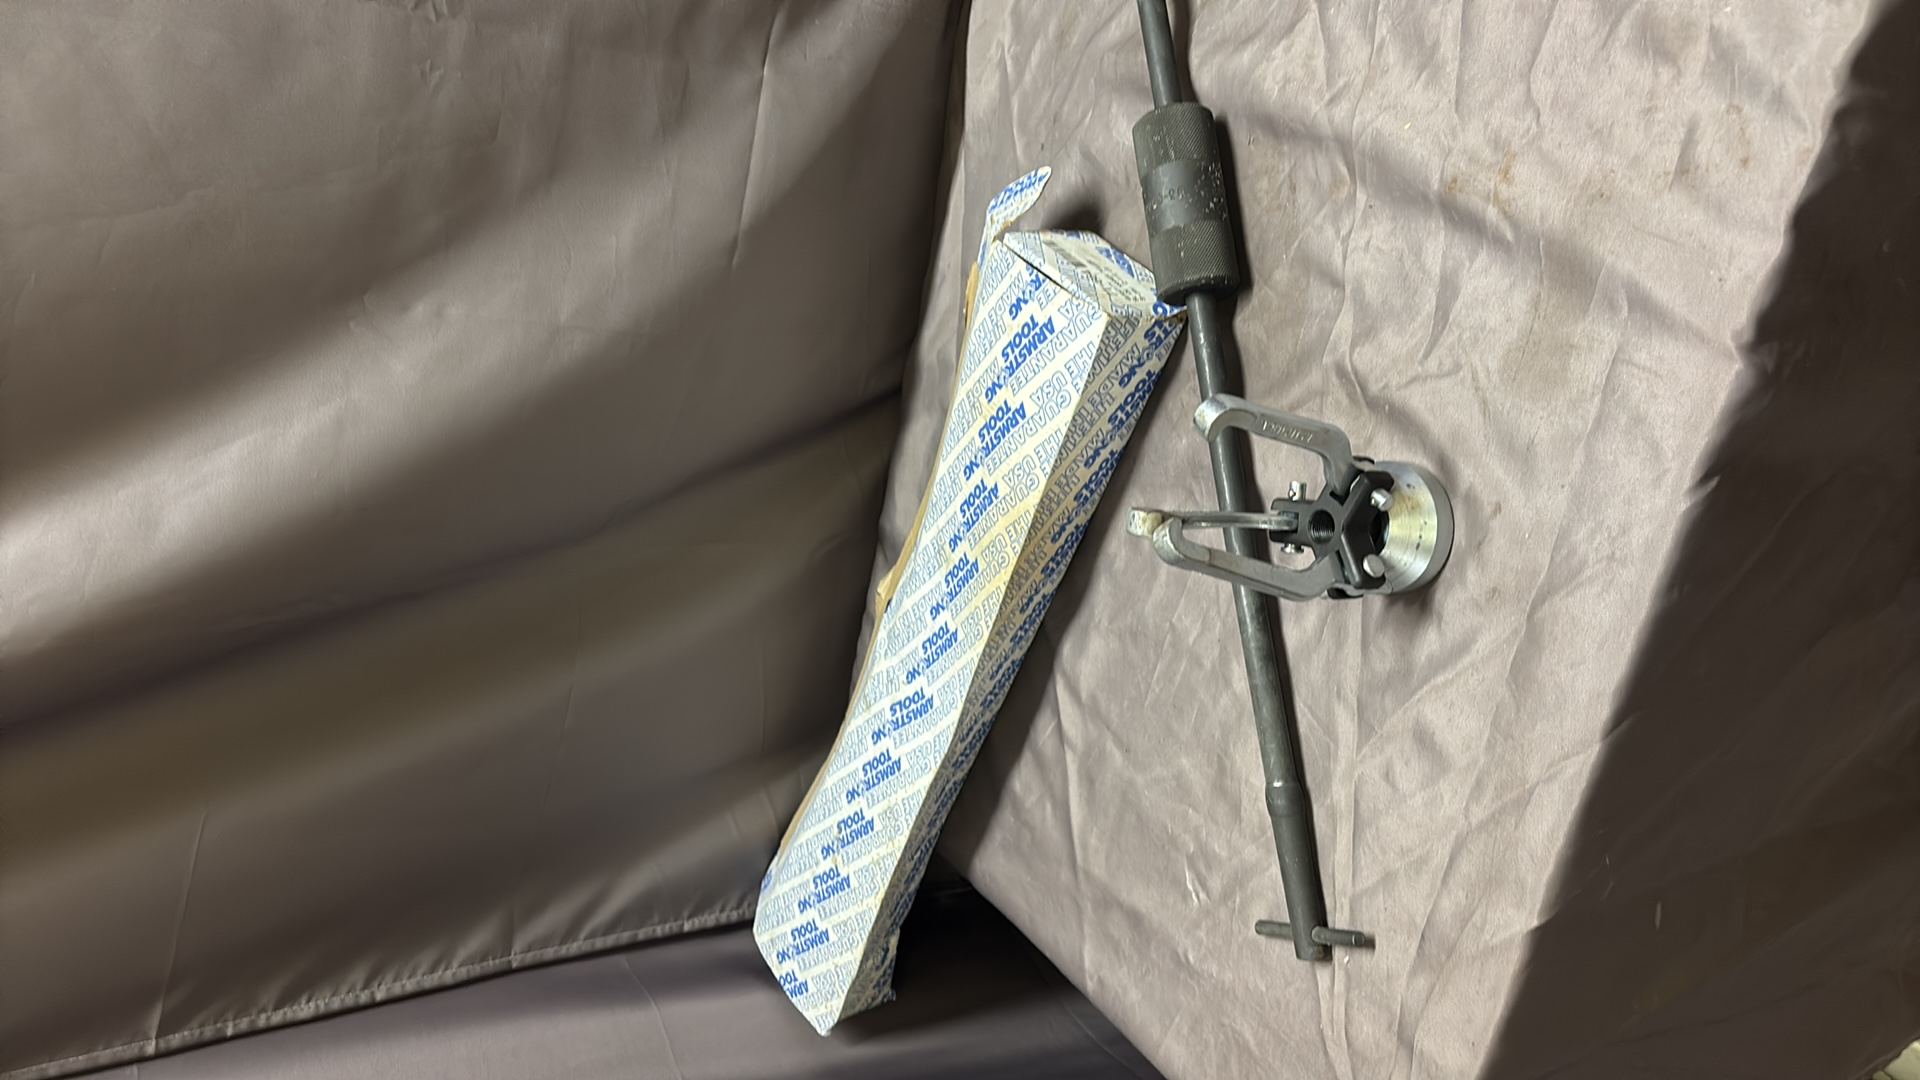


[gs://auction-images-bucket/aypt2025-13/10_1.jpg] labels=0


In [122]:
import re

bucket_name = 'auction-images-bucket'
bucket = storage_client.bucket(bucket_name)
auction = 'aypt2025-13'
prefix = auction + '/'

regex_capture = re.compile(rf"^{re.escape(prefix)}(?P<item>\d+)_(?P<idx>\d+)\.[^/\.]+$")

items = {} # Dictionary of items that will be filled dynamically
for blob in bucket.list_blobs(prefix=prefix):
  if not blob.name.startswith(f"{auction}/10_1."):
      continue
  debug_label_gcs_uri(bucket_name, blob.name)

# End Test on image not working

# Testing on images stored in Google Drive

## Ryobi

In [98]:
client = vision.ImageAnnotatorClient()

# Read image as a byte file
with open("Images/10_1.jpg", "rb") as f:
    content = f.read()

# Pass in a byte file image to Vision.Image creating a client image on which the vision API tasks can be performed
image = vision.Image(content=content)

text = client.text_detection(image=image) # Extracts text from the image
label = client.label_detection(image=image) # labels the items in the image

print("Text error message:", text.error.message)
print("Label error message:", label.error.message)
label

Text error message: 
Label error message: 


label_annotations {
  mid: "/m/03vtbc"
  description: "Silver"
  score: 0.748863339
  topicality: 0.00255370536
}
label_annotations {
  mid: "/m/0155hn"
  description: "Carbon fibers"
  score: 0.601386845
  topicality: 0.000479051494
}
label_annotations {
  mid: "/m/025sk56"
  description: "Titanium"
  score: 0.594534338
  topicality: 0.000815228792
}
label_annotations {
  mid: "/m/025s4r7"
  description: "Nickel"
  score: 0.510833085
  topicality: 0.000313805736
}

In [93]:
label

label_annotations {
  mid: "/m/03vtbc"
  description: "Silver"
  score: 0.748863339
  topicality: 0.00255370536
}
label_annotations {
  mid: "/m/0155hn"
  description: "Carbon fibers"
  score: 0.601386845
  topicality: 0.000479051494
}
label_annotations {
  mid: "/m/025sk56"
  description: "Titanium"
  score: 0.594534338
  topicality: 0.000815228792
}
label_annotations {
  mid: "/m/025s4r7"
  description: "Nickel"
  score: 0.510833085
  topicality: 0.000313805736
}

In [94]:
# Get all of the individual texts from the text_annotations
texts = []
for t in text.text_annotations[1:]:
  if t.description not in texts:
    texts.append(t.description)

texts

[]

In [95]:
# Get all of the individual labels from the label_annotations
labels = []
for l in label.label_annotations:
  labels.append(l.description)

labels

['Silver', 'Carbon fibers', 'Titanium', 'Nickel']

In [96]:
text

In [97]:
label

label_annotations {
  mid: "/m/03vtbc"
  description: "Silver"
  score: 0.748863339
  topicality: 0.00255370536
}
label_annotations {
  mid: "/m/0155hn"
  description: "Carbon fibers"
  score: 0.601386845
  topicality: 0.000479051494
}
label_annotations {
  mid: "/m/025sk56"
  description: "Titanium"
  score: 0.594534338
  topicality: 0.000815228792
}
label_annotations {
  mid: "/m/025s4r7"
  description: "Nickel"
  score: 0.510833085
  topicality: 0.000313805736
}

## Chair

In [17]:
client = vision.ImageAnnotatorClient()

# Read image as a byte file
with open("Images/31_1.jpg", "rb") as f:
    content = f.read()

# Pass in a byte file image to Vision.Image creating a client image on which the vision API tasks can be performed
image = vision.Image(content=content)

text = client.text_detection(image=image) # Extracts text from the image
label = client.label_detection(image=image) # labels the items in the image

print("Text error message:", text.error.message)
print("Label error message:", label.error.message)

Text error message: 
Label error message: 


In [18]:
label

label_annotations {
  mid: "/m/083vt"
  description: "Wood"
  score: 0.967929602
  topicality: 0.262388945
}
label_annotations {
  mid: "/m/09q2t"
  description: "Brown"
  score: 0.926974654
  topicality: 0.0336198509
}
label_annotations {
  mid: "/m/05t06b"
  description: "Wood stain"
  score: 0.738566279
  topicality: 0.00136940635
}
label_annotations {
  mid: "/m/020g49"
  description: "Hardwood"
  score: 0.735686958
  topicality: 0.00219393242
}
label_annotations {
  mid: "/m/0jh8w"
  description: "Plywood"
  score: 0.628911257
  topicality: 0.00300702476
}
label_annotations {
  mid: "/m/04lbp"
  description: "Leather"
  score: 0.518466
  topicality: 0.0688842908
}

In [ ]:
cloud_object = client.object_localization(image=image)

In [ ]:
for x in cloud_object.localized_object_annotations:
  print(x.name)

Chair


# End Test on images loaded from google drive